In [2]:
import pandas as pd
import pymc as pm
import arviz as az

df = pd.read_csv('./data/fm_data.csv')
df = df[df['TYPE'] == 'Standard (1-way)']
df.columns

Index(['team', 'merge_name', 'season', 'playerId', 'name', 'position',
       'games_played', 'icetime', 'faceoffsWon', 'penalityMinutes',
       'shotsBlockedByPlayer', 'I_F_points', 'I_F_dZoneGiveaways', 'I_F_hits',
       'AGE', 'TYPE', 'EXTENSION', 'SIGNING AGE', 'LENGTH', 'SALARY', 'Team',
       'State/Prov', 'Country', 'Conference', 'Division', 'O6', 'EffTaxRate',
       'L_Salary', 'xGoals_diff', 'faceoffsWon_per60', 'penalityMinutes_per60',
       'shotsBlockedByPlayer_per60', 'I_F_points_per60',
       'I_F_dZoneGiveaways_per60', 'I_F_hits_per60', 'xGoals_diff_per60'],
      dtype='object')

In [3]:
categorical_indices = {}
player_indices = {}

player_stat_columns = [
    'xGoals_diff', 'penalityMinutes_per60', 'shotsBlockedByPlayer_per60', 
    'I_F_points_per60', 'I_F_dZoneGiveaways_per60', 'I_F_hits_per60'
]

county_columns = ['EffTaxRate']

# df['team'].factorize()
for var in ['team', 'name', 'position', 'Country', 'TYPE', 'EXTENSION', 'O6']:
    player_cat_index, cat_values = df[var].factorize()
    categorical_indices.update({var: cat_values.values})
    player_indices.update({var: player_cat_index})

# 
coords = categorical_indices
coords.update({'player_stats': player_stat_columns})


In [24]:

categorical_uniques = pd.DataFrame(player_indices).merge(df['EffTaxRate'].reset_index(drop=True), left_index=True, right_index=True)
cdf = categorical_uniques[['team', 'Country', 'O6', 'EffTaxRate']].drop_duplicates()
cdf.head()


,team,Country,O6,EffTaxRate
0,0,0,0,0.466
129,1,0,0,0.412
237,2,0,1,0.415
370,3,0,0,0.432
496,4,0,0,0.420


In [10]:
import numpy as np
X = df[player_stat_columns]
p_idx = player_indices
with pm.Model(coords=coords) as model:
    
    global_salary = pm.Normal('global_salary', 14, 2)
    global_salary_exp = pm.Deterministic('global_salary_exp', np.exp(global_salary))
    team_sigma = pm.HalfNormal('team_sigma', 1)

    # TODO: add position intercept?
    position_sigma = pm.HalfNormal('position_sigma', 1)

    # remove because they have almost no impact and are highly correlated
    # country_beta = pm.Normal('country_beta', 0, 5, dims='Country')
    # o6_beta = pm.Normal('o6_beta', 0, 5, dims='O6')
    tax_beta = pm.Normal('tax_beta', 0, 5)

    intercept = pm.Deterministic('intercept', global_salary + tax_beta * cdf['EffTaxRate'].values, dims='team') 
    team_offset = pm.Normal('team_offset', 0, 2, dims='team')
    team_intercept = pm.Deterministic('team_intercept', intercept + team_offset*team_sigma, dims='team')
    team_intercept_exp = pm.Deterministic('team_intercept_exp', np.exp(team_intercept), dims='team')
    
    player_stats_global = pm.Laplace('player_stats_global', 0, 10, dims='player_stats')
    player_stats_sigma = pm.HalfNormal('player_position_sigma', 2, dims='player_stats')

    position_za = pm.Laplace("za_position", 0.0, 10, dims=("position", "player_stats")) 
    player_stats_position = pm.Deterministic('player_stats_position', player_stats_global + position_za * player_stats_sigma, dims=['position', 'player_stats'])

    contract_mu = team_intercept[p_idx['team']] + (X.values * player_stats_position[p_idx['position']]).sum(axis=1)

    salary_sigma = pm.HalfCauchy('salary_sigma', 5)
    y = pm.Cauchy('log_salary', contract_mu, salary_sigma, observed = df['L_Salary'])



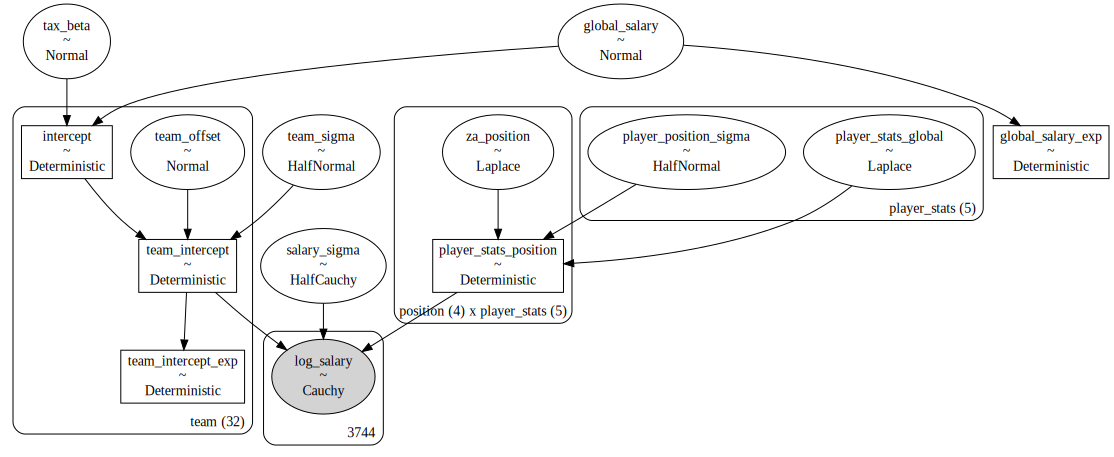

In [11]:

pm.model_to_graphviz(model)

In [14]:
with model:
    trace = pm.sample(1000, target_accept=0.975)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_salary, team_sigma, tax_beta, team_offset, player_stats_global, player_position_sigma, za_position, salary_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 398 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


['penalityMinutes_per60', 'shotsBlockedByPlayer_per60', 'I_F_points_per60', 'I_F_dZoneGiveaways_per60', 'I_F_hits_per60']


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

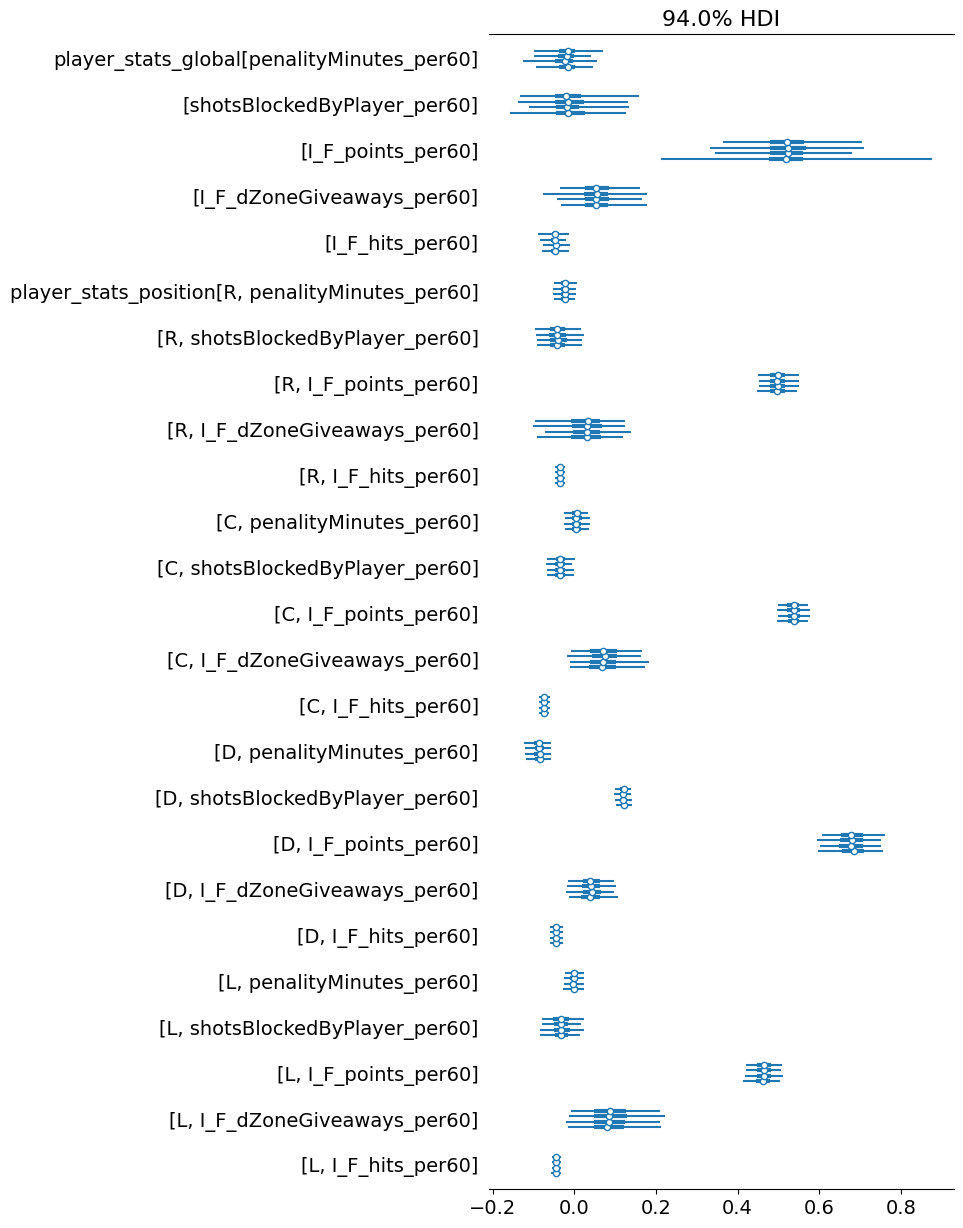

In [16]:
# trace.to_json(filename='output_posterior.json')
print(player_stat_columns)
az.plot_forest(trace, var_names=['player_stats_global', 'player_stats_position'], coords = {})


array([[<Axes: title={'center': 'global_salary_exp'}>,
        <Axes: title={'center': 'global_salary_exp'}>],
       [<Axes: title={'center': 'tax_beta'}>,
        <Axes: title={'center': 'tax_beta'}>],
       [<Axes: title={'center': 'team_intercept_exp'}>,
        <Axes: title={'center': 'team_intercept_exp'}>],
       [<Axes: title={'center': 'player_stats_global'}>,
        <Axes: title={'center': 'player_stats_global'}>],
       [<Axes: title={'center': 'player_stats_position'}>,
        <Axes: title={'center': 'player_stats_position'}>]], dtype=object)

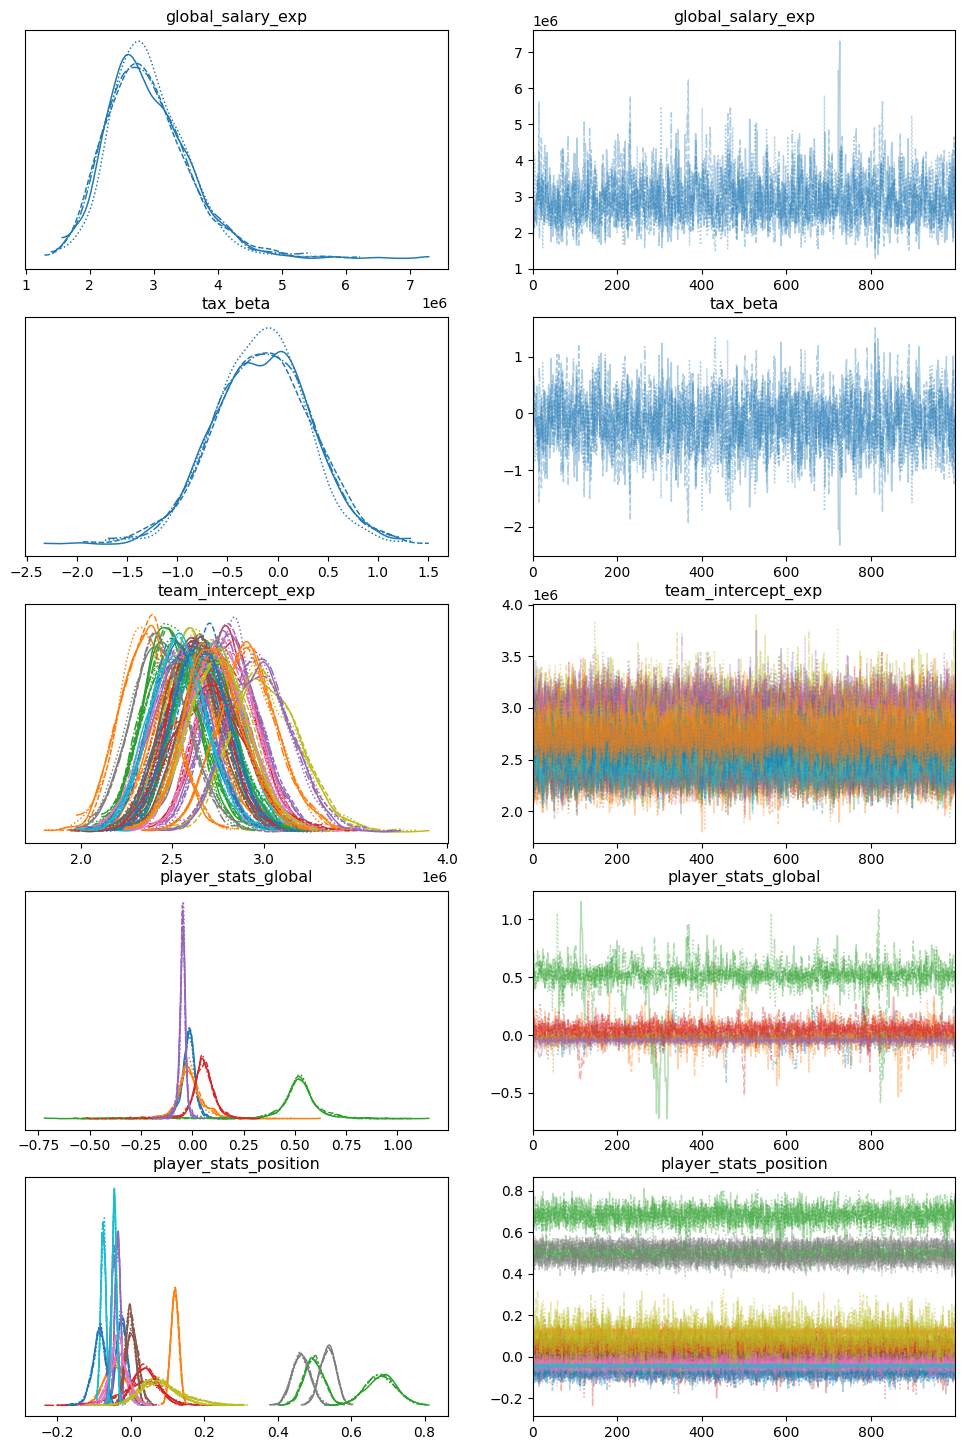

In [20]:
# az.plot_trace(trace.posterior, coords={'TYPE': ['Standard (1-way)', 'Standard (2-way)'], 'team': ['BOS', 'TBL'], 'position': ['C']})
# az.plot_trace(trace.posterior, figsize=(12, 24), var_names = ['player_stats_position', 'player_stats_global'], coords={'player_stats': 'I_F_points_per60'})
az.plot_trace(trace, figsize=(12, 18), divergences=False, var_names=['global_salary_exp', 'tax_beta', 'team_intercept_exp', 'player_stats_global', 'player_stats_position'])

In [ ]:
# az.plot_forest(trace, coords={'TYPE': 'Standard (1-way)', 'position': ['L']}, var_names=['team_salary'])
print(player_stat_columns)
az.plot_forest(trace, var_names=['player_stats_global', 'player_stats_position'], coords = {})

In [23]:
az.summary(trace, var_names=['global_salary_exp', 'team_intercept_exp', 'tax_beta', 'player_stats_global', 'player_stats_position']).to_csv('trace_output.csv')
trace.to_json('output_trace.json')

'output_trace.json'